In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datasets.tensor_storage import TensorStorage
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
# import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP
import ncvis
import time

In [5]:
dim_experiment_id = "deepinfomax_20241218_052013"
ae_experiment_id = "autoencoder_20241218_054318"

In [6]:
dim_store = TensorStorage(f"storages/{dim_experiment_id}")
ae_store = TensorStorage(f"storages/{ae_experiment_id}")

In [12]:
def reduce_and_plot_embeddings(embeddings, metadata_df, split='train', methods=None):
    """Apply different dimensionality reduction methods and plot results."""
    if methods is None:
        # methods = ['tsne', 'umap', 'ncvis']
        methods = ['ncvis']
        
    # CIFAR-10 class names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    
    # Filter by split
    split_mask = metadata_df['split'] == split
    split_embeddings = embeddings[split_mask]
    split_labels = metadata_df[split_mask]['label'].values
    
    # Dictionary to store reduced embeddings
    reduced_embeddings = {}
    times = {}
    
    # Apply each method
    for method in methods:
        print(f"\nApplying {method.upper()}...")
        start_time = time.time()
        
        if method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
            reduced_embeddings[method] = reducer.fit_transform(split_embeddings)
        elif method == 'umap':
            reducer = UMAP(n_components=2, random_state=42)
            reduced_embeddings[method] = reducer.fit_transform(split_embeddings)
        elif method == 'ncvis':
            reducer = ncvis.NCVis()  # Use all available cores
            reduced_embeddings[method] = reducer.fit_transform(split_embeddings)
            
        times[method] = time.time() - start_time
        print(f"{method.upper()} took {times[method]:.2f} seconds")
    
    # Plotting
    n_methods = len(methods)
    fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))
    if n_methods == 1:
        axes = [axes]
    
    # Use a colorful and visually appealing palette
    palette = sns.color_palette('husl', n_colors=len(class_names))
    
    for ax, method in zip(axes, methods):
        embeddings_2d = reduced_embeddings[method]
        
        # Plot each class
        for label in range(len(class_names)):
            mask = split_labels == label
            ax.scatter(
                embeddings_2d[mask, 0],
                embeddings_2d[mask, 1],
                c=[palette[label]],
                label=class_names[label],
                alpha=0.6,
                s=50
            )
        
        # Customize the plot
        ax.set_title(f'{method.upper()}\n({times[method]:.2f} sec)', pad=20)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Add legend to the last plot
    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig, reduced_embeddings, times

In [13]:
def load_embeddings_and_metadata(store):
    metadata_df = store.load_metadata_table()
    
    # Load all embeddings into memory
    embeddings = []
    for i in tqdm(range(len(store)), desc="Loading embeddings"):
        embeddings.append(store[i])
    
    return np.array(embeddings), metadata_df

In [14]:
dim_embeddings, dim_metadata_df = load_embeddings_and_metadata(dim_store)

Loading embeddings: 100%|██████████| 54912/54912 [00:00<00:00, 287027.33it/s]


In [15]:
ae_embeddings, ae_metadata_df = load_embeddings_and_metadata(ae_store)

Loading embeddings: 100%|██████████| 54912/54912 [00:00<00:00, 281179.99it/s]


Applying dimensionality reduction to DeepInfoMax embeddings...

Applying NCVIS...
NCVIS took 43.59 seconds


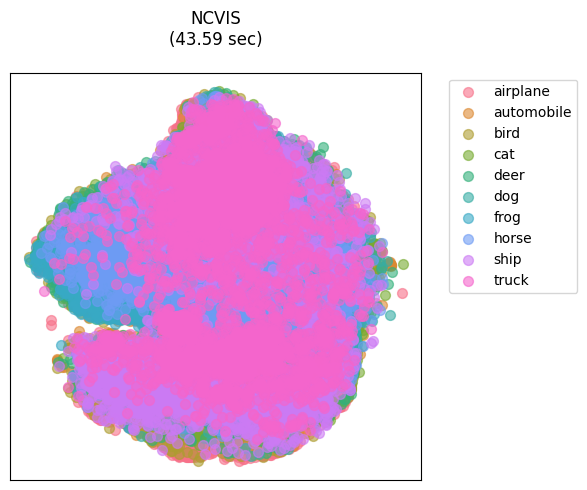

In [16]:
print("Applying dimensionality reduction to DeepInfoMax embeddings...")
dim_fig, dim_reduced, dim_times = reduce_and_plot_embeddings(
    dim_embeddings, dim_metadata_df, split='train'
)